In [253]:
import pandas as pd
import pm4py

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.statistics.traces.generic.log import case_statistics

import matplotlib.pyplot as plt

In [254]:
# Data Import:
xes_path = "/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

# Read the XES log
event_log = xes_importer.apply(xes_path)

parsing log, completed traces :: 100%|██████████| 31509/31509 [00:26<00:00, 1205.39it/s]


In [255]:
# Transform the event log to a pandas DataFrame
df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

### First look -> inductive petri net

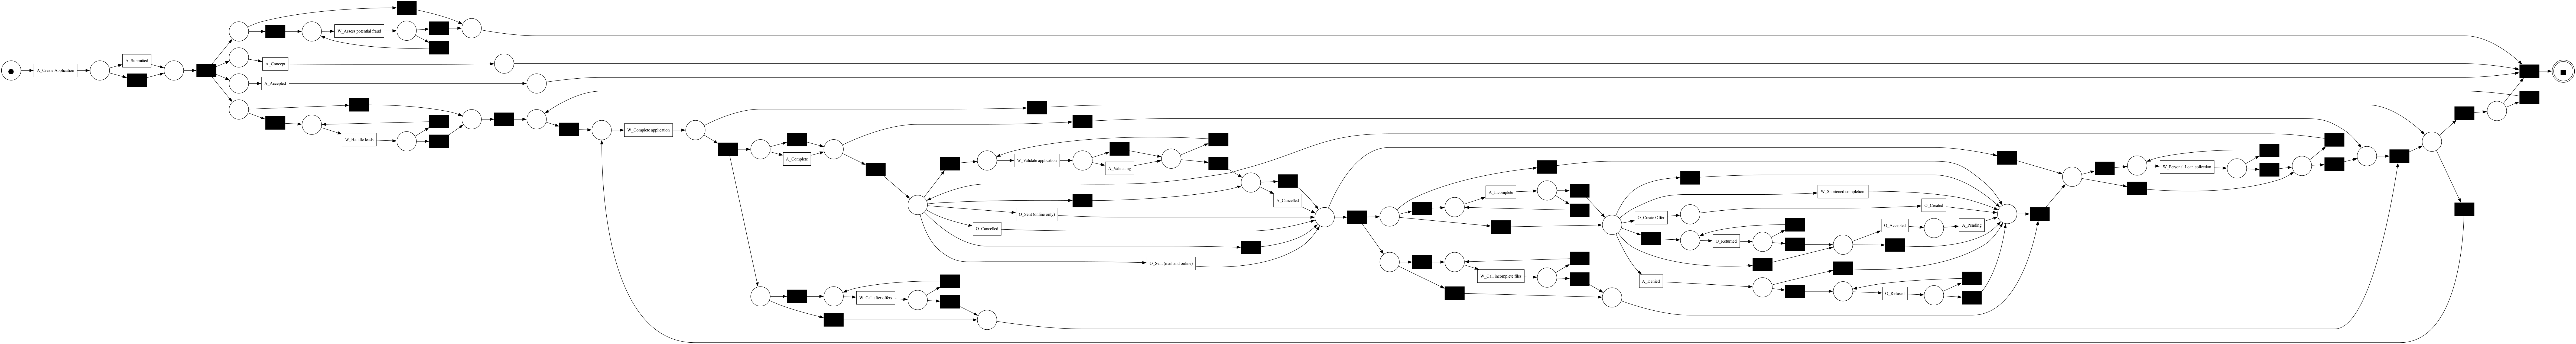

In [256]:
net, im, fm = pm4py.discover_petri_net_inductive(
                        event_log,
                activity_key="concept:name",
                case_id_key="case:concept:name",
                timestamp_key="time:timestamp",
            )
pm4py.view_petri_net(net, im, fm )

In [276]:
analytics_init = eval_petri(net, im, fm)
print(analytics_init)

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:45<00:00, 349.45it/s]


Fitness:  {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [19:41<00:00, 223.40it/s] 


Precision:  0.1406587530076867


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:44<00:00, 361.21it/s]


Generalization:  0.9484917562396579
Simplicity:  0.6283185840707964
Custom Simplicity 1 — Arc Density: 0.009125173576671296
Custom Simplicity 2 — Control-Flow Complexity: 10
({'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 0.1406587530076867, 0.9484917562396579, 0.6283185840707964, 0.009125173576671296, 10)


### Preprocessing

In [257]:
# Filter rare end_activities & start_activities

end_activities = pm4py.get_end_activities(
    df,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

end_activities_series = pd.Series(end_activities)

rare_end_activities_threshold = 1000
rare_end_activities = end_activities_series[end_activities_series <= rare_end_activities_threshold].index.tolist()
print(rare_end_activities)

# remove traces ending with rare end activities
filtered_df_v2 = pm4py.filter_end_activities(
    log=filtered_df_v1,
    activities=rare_end_activities,
    retain=False,               
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

['W_Complete application', 'W_Assess potential fraud', 'W_Personal Loan collection', 'W_Shortened completion ', 'A_Denied', 'O_Sent (online only)', 'O_Sent (mail and online)', 'O_Returned']


In [258]:
end_activities_series

W_Validate application        12662
O_Cancelled                    4436
W_Call after offers            9457
W_Call incomplete files        4676
W_Complete application          144
W_Assess potential fraud        102
W_Personal Loan collection        2
W_Shortened completion            5
A_Denied                          1
O_Sent (online only)              8
O_Sent (mail and online)         15
O_Returned                        1
dtype: int64

In [259]:
# Filter extremely long and short traces:

trace_lengths = filtered_df_v2.groupby('case:concept:name')['concept:name'].count()

min_length = trace_lengths.quantile(0.01) 
max_length = trace_lengths.quantile(0.99)

filtered_df_v3 = pm4py.filter_case_size(
    filtered_df_v2,
    min_size=min_length,
    max_size=max_length,
    case_id_key='case:concept:name'
)

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/pm4py/algo/filtering/pandas/cases/case_filter.py:103: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[element_group_size <= max_case_size]


In [260]:
variants_count = pm4py.get_variants(
    filtered_df_v3,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)
len(variants_count)

11372

### second look after initial filtering

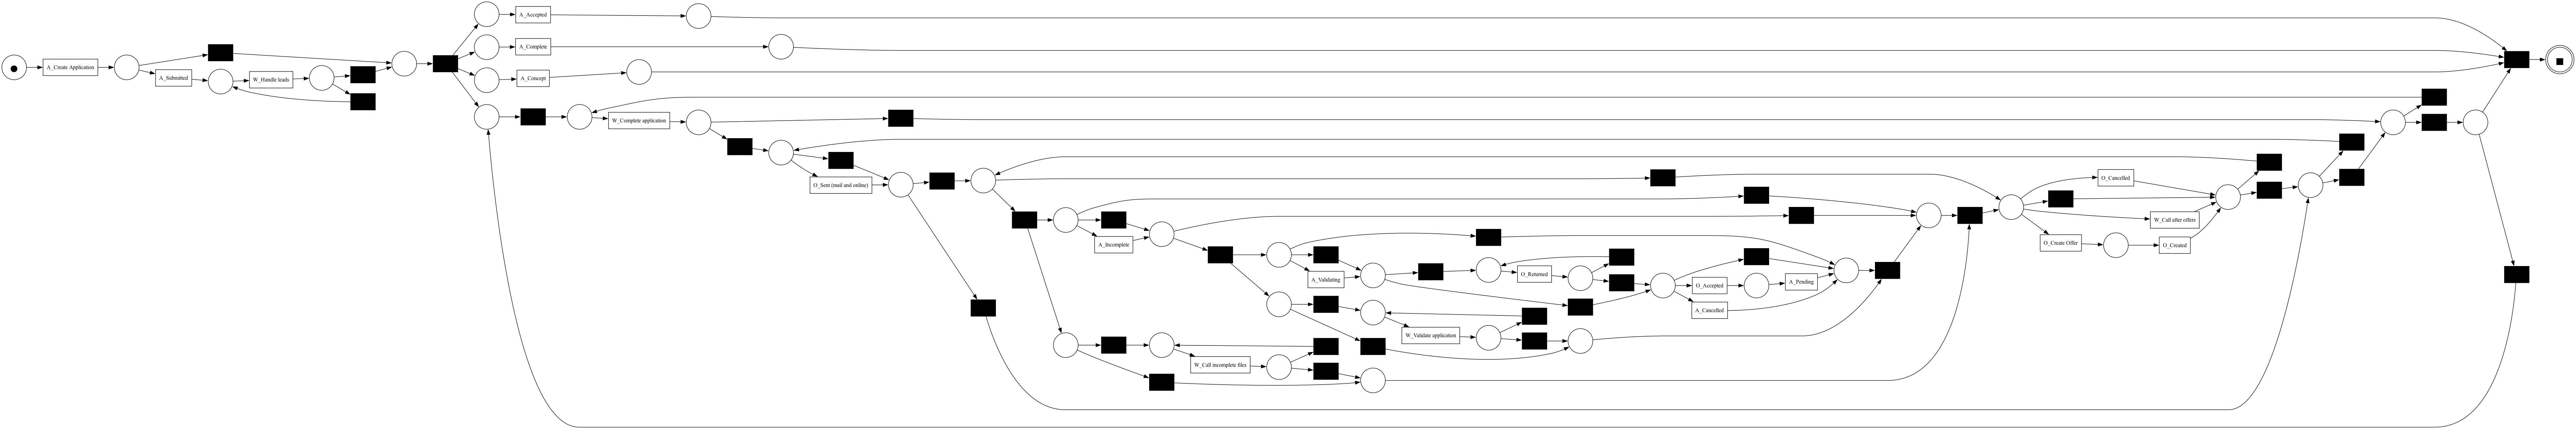

In [261]:
sec_net, sec_im, sec_fm = pm4py.discover_petri_net_inductive(
                filtered_df_v3,
                activity_key="concept:name",
                case_id_key="case:concept:name",
                timestamp_key="time:timestamp",
            )
pm4py.view_petri_net(sec_net, sec_im, sec_fm)

In [277]:
analysis_sec = eval_petri(sec_net, sec_im, sec_fm)
print(analysis_sec)

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:36<00:00, 436.49it/s]


Fitness:  {'perc_fit_traces': 99.5334666285823, 'average_trace_fitness': 0.9997524983182543, 'log_fitness': 0.9998981569819976, 'percentage_of_fitting_traces': 99.5334666285823}


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [17:21<00:00, 253.51it/s] 


Precision:  0.16504902752399908


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:35<00:00, 450.09it/s]


Generalization:  0.9750503568658166
Simplicity:  0.6341463414634145
Custom Simplicity 1 — Arc Density: 0.01238905325443787
Custom Simplicity 2 — Control-Flow Complexity: 10
({'perc_fit_traces': 99.5334666285823, 'average_trace_fitness': 0.9997524983182543, 'log_fitness': 0.9998981569819976, 'percentage_of_fitting_traces': 99.5334666285823}, 0.16504902752399908, 0.9750503568658166, 0.6341463414634145, 0.01238905325443787, 10)


In [262]:
len(filtered_df_v3['case:concept:name'].unique())

25398

### Further Filtering

In [263]:
# filter by variants with max_rep = 2

variants_count = pm4py.get_variants(
    filtered_df_v3,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp',
    max_repetitions=1 #2 
)

In [264]:
# Conditional Filtering
from collections import Counter

def subsequence_counts(variants, k=2):
    counts = Counter()
    for trace, count in variants.items():
        n = len(trace)
        for length in range(1, k+1):
            for i in range(n - length + 1):
                subseq = trace[i:i+length]
                counts[tuple(subseq)] += count
    return counts

# Count subsequences up to length 2
subseq_counts = subsequence_counts(variants_count, k=2)

conditional_probs = {}

for subseq in subseq_counts:
    if len(subseq) < 1:
        continue
    prefix = subseq[:-1]
    next_act = subseq[-1]
    if prefix:
        conditional_probs[(next_act, prefix)] = subseq_counts[subseq] / subseq_counts[prefix]

In [265]:
from typing import Dict, Tuple, Set
import pandas as pd

def detect_outlier_traces(
    df: pd.DataFrame,
    conditional_probs: Dict[Tuple[str, Tuple[str, ...]], float],
    case_id_key: str = "case:concept:name",
    activity_key: str = "concept:name",
    tau: float = 0.01,
    prefix_len: int = 1
) -> Set[str]:
    """
    Detect traces containing outlier behavior based on conditional probabilities.

    :param df: Preprocessed event log as Pandas DataFrame.
    :param conditional_probs: Dictionary {(next_act, prefix_tuple): cp_value}.
    :param case_id_key: Column name for case IDs.
    :param activity_key: Column name for activities.
    :param tau: Threshold for flagging an activity as outlier.
    :param prefix_len: Number of previous activities to use as prefix.
    :return: Set of case IDs containing outlier traces.
    """
    outlier_cases = set()

    for case_id, group in df.groupby(case_id_key):
        trace = list(group[activity_key])
        n = len(trace)
        
        for i in range(n):
            # get prefix of correct length
            if i < prefix_len:
                prefix = tuple(trace[:i])  # shorter prefix at start
            else:
                prefix = tuple(trace[i-prefix_len:i])
            
            next_act = trace[i]
            # lookup cp, default=1 for seen sequences, tau checks only rare ones
            cp_value = conditional_probs.get((next_act, prefix), 1)
            
            if cp_value <= tau:
                outlier_cases.add(case_id)
                break  # no need to check rest of trace

    return outlier_cases


In [266]:
dict(sorted(conditional_probs.items(), key=lambda x: x[1], reverse=True))

{('W_Handle leads', ('A_Submitted',)): 1.0,
 ('W_Complete application', ('W_Handle leads',)): 1.0,
 ('O_Created', ('O_Create Offer',)): 1.0,
 ('A_Pending', ('O_Accepted',)): 1.0,
 ('O_Cancelled', ('A_Cancelled',)): 0.9871611982881597,
 ('W_Call after offers', ('A_Complete',)): 0.9744468068351839,
 ('W_Call incomplete files', ('A_Incomplete',)): 0.9708502024291498,
 ('O_Create Offer', ('A_Accepted',)): 0.9506260335459485,
 ('W_Validate application', ('O_Returned',)): 0.9361124232404345,
 ('O_Sent (mail and online)', ('O_Created',)): 0.8737746581144863,
 ('W_Complete application', ('O_Sent (mail and online)',)): 0.8562470500977681,
 ('W_Validate application', ('A_Pending',)): 0.7131073591957726,
 ('W_Complete application', ('A_Concept',)): 0.7123395542956138,
 ('W_Call after offers', ('O_Cancelled',)): 0.6528703047484054,
 ('A_Submitted', ('A_Create Application',)): 0.6459170013386881,
 ('O_Returned', ('A_Validating',)): 0.5475194261805141,
 ('W_Validate application', ('A_Validating',)):

In [267]:
tau = 0.01
prefix_len = 1  # must match how conditional_probs were built

outlier_cases = detect_outlier_traces(
    df=filtered_df_v3,
    conditional_probs=conditional_probs,
    tau=tau,
    prefix_len=prefix_len
)

print(f"Number of outlier traces: {len(outlier_cases)}")

filtered_df_v4 = filtered_df_v3[~filtered_df_v3['case:concept:name'].isin(outlier_cases)]


Number of outlier traces: 2561


In [268]:
len(filtered_df_v4['case:concept:name'].unique())

22837

In [269]:
print(outlier_cases)

{'Application_1692002404', 'Application_501431890', 'Application_169347982', 'Application_552235286', 'Application_587334519', 'Application_275583545', 'Application_236009431', 'Application_1541539359', 'Application_1921127090', 'Application_1703692771', 'Application_704781974', 'Application_809034186', 'Application_1446096185', 'Application_1656510218', 'Application_790322789', 'Application_1878767958', 'Application_1210322027', 'Application_288862349', 'Application_1239060176', 'Application_317319031', 'Application_686543746', 'Application_1654873364', 'Application_572814439', 'Application_20502706', 'Application_947106743', 'Application_112118887', 'Application_515101580', 'Application_1975316215', 'Application_151057328', 'Application_2041039158', 'Application_948081892', 'Application_1376787082', 'Application_616058642', 'Application_2109817580', 'Application_1557848417', 'Application_623268834', 'Application_70563300', 'Application_2114671174', 'Application_1931690466', 'Applicat

In [270]:
# Convert filtered_df to log
log_clean = pm4py.convert_to_event_log(filtered_df_v4)

### Evaluation

In [271]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

def eval_petri(net, im, fm):
    # Fitness
    fitness = replay_fitness.apply(event_log, net, im, fm, variant=replay_fitness.Variants.TOKEN_BASED)
    print(f"Fitness: ", fitness)

    # Precision
    
    precision = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    print(f"Precision: ", precision)

    # Generalization
    
    generalization = generalization_evaluator.apply(event_log, net, im, fm)
    print(f"Generalization: ", generalization)

    # Simplicity
    simplicity = simplicity_evaluator.apply(net)
    print(f"Simplicity: ", simplicity)

    #CUSTOM ===========

    # --- Custom Simplicity Metrics ---

    arc_density = custom_arc_density(net)
    print("Custom Simplicity 1 — Arc Density:", arc_density)

    cfc = custom_control_flow_complexity(net)
    print("Custom Simplicity 2 — Control-Flow Complexity:", cfc)

    return fitness, precision, generalization, simplicity, arc_density, cfc

def custom_arc_density(net):
    """
    Custom Simplicity Metric #1:
    Arc Density = number_of_arcs / (number_of_nodes^2)
    Lower values = simpler model.
    """
    num_arcs = len(net.arcs)
    num_nodes = len(net.places) + len(net.transitions)

    if num_nodes == 0:
        return 0.0

    density = num_arcs / (num_nodes ** 2)
    return density


def custom_control_flow_complexity(net):
    """
    Custom Simplicity Metric #2:
    Control-Flow Complexity (CFC)
    Number of split/join transitions:
      - splits: transitions with >1 outgoing arc
      - joins: transitions with >1 incoming arc
    Lower values = simpler model.
    """
    cfc = 0

    for t in net.transitions:
        outgoing = len([a for a in net.arcs if a.source == t])
        incoming = len([a for a in net.arcs if a.target == t])

        # XOR / AND / OR splits and joins are collectively counted
        if outgoing > 1:
            cfc += (outgoing - 1)
        if incoming > 1:
            cfc += (incoming - 1)

    return cfc

def count_model_elements(net):
    """
    Returns:
      - number of places
      - number of transitions
      - number of arcs
      - total number of nodes
    """
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    num_nodes = num_places + num_transitions

    return num_places, num_transitions, num_arcs, num_nodes

# Process Discovery

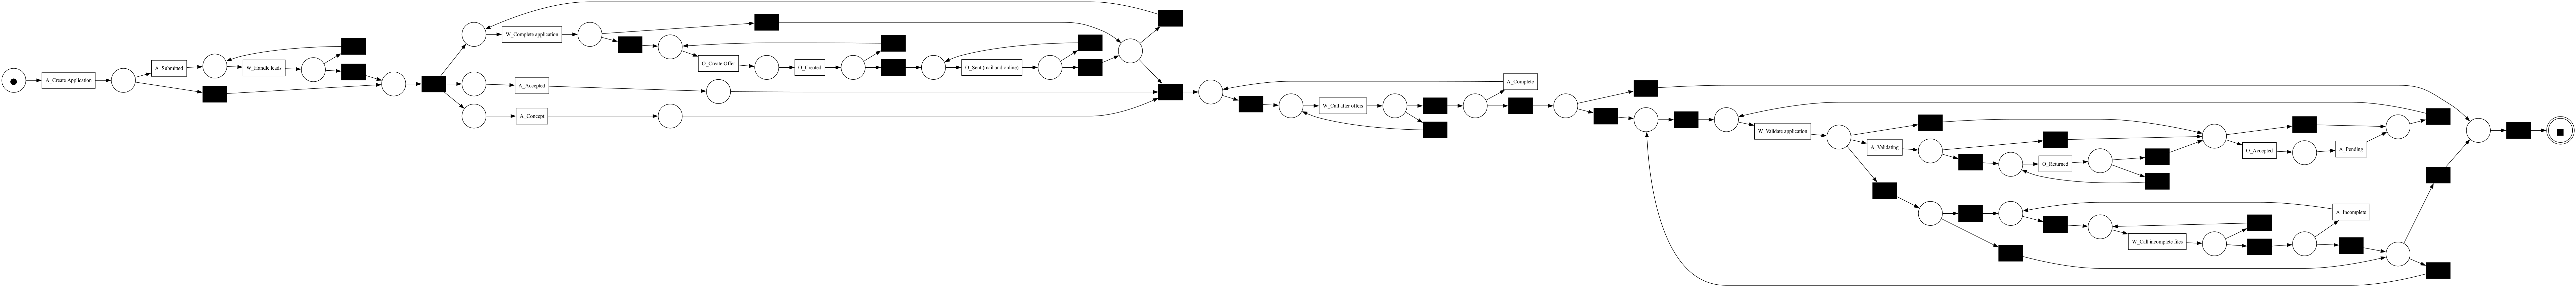

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:30<00:00, 527.36it/s]


Fitness:  {'perc_fit_traces': 64.40699482687486, 'average_trace_fitness': 0.9948983352091826, 'log_fitness': 0.9948613701764042, 'percentage_of_fitting_traces': 64.40699482687486}


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [07:34<00:00, 580.40it/s] 


Precision:  0.503746987271704


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:29<00:00, 534.86it/s]


Generalization:  0.9914366066430647
Simplicity:  0.7099236641221374
Custom Simplicity 1 — Arc Density: 0.01294947392762169
Custom Simplicity 2 — Control-Flow Complexity: 4
({'perc_fit_traces': 64.40699482687486, 'average_trace_fitness': 0.9948983352091826, 'log_fitness': 0.9948613701764042, 'percentage_of_fitting_traces': 64.40699482687486}, 0.503746987271704, 0.9914366066430647, 0.7099236641221374, 0.01294947392762169, 4)


In [272]:
# Inductive Miner: 
in_net, in_im, in_fm = pm4py.discover_petri_net_inductive(
                        filtered_df_v4,
                activity_key="concept:name",
                case_id_key="case:concept:name",
                timestamp_key="time:timestamp",
                noise_threshold=0.11
            )
pm4py.view_petri_net(in_net, in_im, in_fm)

analysis_in = eval_petri(in_net, in_im, in_fm)
print(analysis_in)

In [246]:
fitness = replay_fitness.apply(event_log, in_net, in_im, in_fm, variant=replay_fitness.Variants.TOKEN_BASED)
print(f"Fitness: ", fitness)

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:31<00:00, 502.57it/s]


Fitness:  {'perc_fit_traces': 64.40699482687486, 'average_trace_fitness': 0.9948983352091826, 'log_fitness': 0.9948613701764042, 'percentage_of_fitting_traces': 64.40699482687486}


In [247]:
precision = precision_evaluator.apply(event_log, in_net, in_im, in_fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"Precision: ", precision)

replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [07:24<00:00, 594.00it/s]


Precision:  0.503746987271704


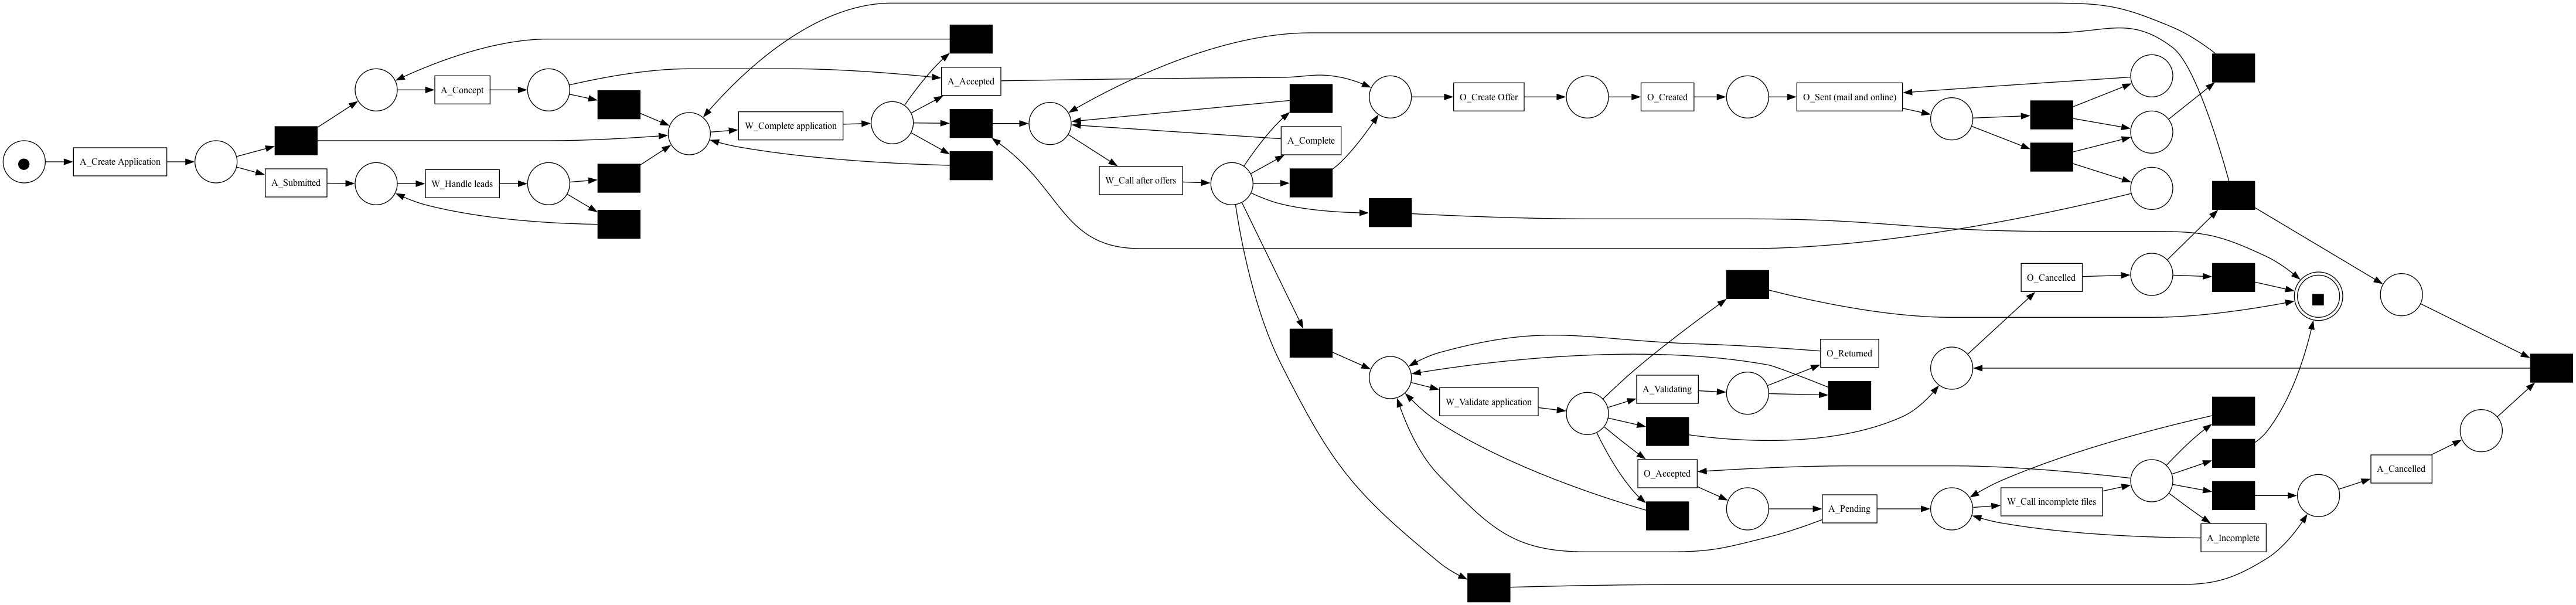

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:31<00:00, 500.61it/s]


Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9342269639956682, 'log_fitness': 0.9422134288915728, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [02:23<00:00, 1845.46it/s]


Precision:  0.7681067477088181


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:32<00:00, 496.43it/s]


Generalization:  0.992157178419546
Simplicity:  0.5873015873015873
Custom Simplicity 1 — Arc Density: 0.018261504747991233
Custom Simplicity 2 — Control-Flow Complexity: 10
({'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9342269639956682, 'log_fitness': 0.9422134288915728, 'percentage_of_fitting_traces': 0.0}, 0.7681067477088181, 0.992157178419546, 0.5873015873015873, 0.018261504747991233, 10)


In [274]:
heu_net, heu_im, heu_fm = pm4py.discover_petri_net_heuristics(
                        filtered_df_v4,
                activity_key="concept:name",
                case_id_key="case:concept:name",
                timestamp_key="time:timestamp",
                #dependency_threshold=0.5
            )
pm4py.view_petri_net(heu_net, heu_im, heu_fm)

analysis_heu = eval_petri(heu_net, heu_im, heu_fm)
print(analysis_heu)

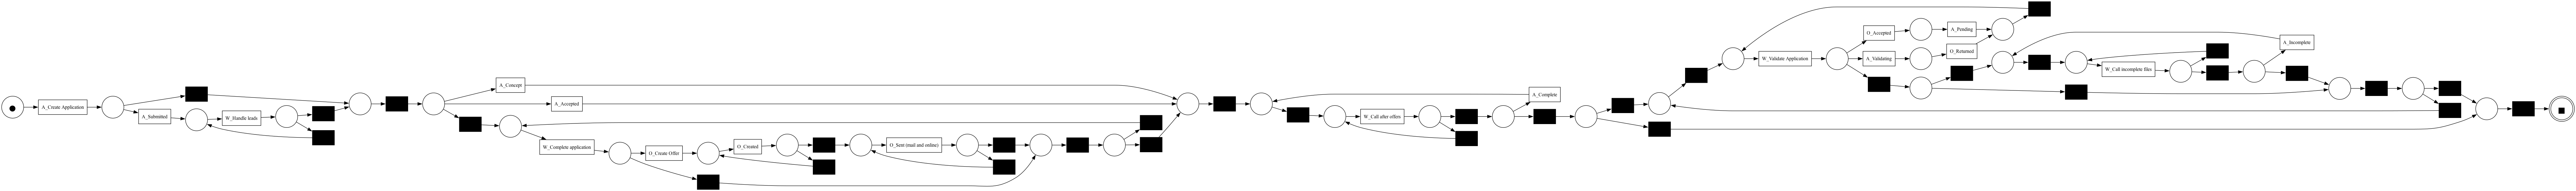

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:55<00:00, 287.65it/s]


Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9302633053997587, 'log_fitness': 0.9307017728684149, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [02:28<00:00, 1781.43it/s]


Precision:  0.5086935695833554


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:56<00:00, 282.67it/s]


Generalization:  0.7217035697029912
Simplicity:  0.7288135593220337
Custom Simplicity 1 — Arc Density: 0.013791238507301243
Custom Simplicity 2 — Control-Flow Complexity: 0
({'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9302633053997587, 'log_fitness': 0.9307017728684149, 'percentage_of_fitting_traces': 0.0}, 0.5086935695833554, 0.7217035697029912, 0.7288135593220337, 0.013791238507301243, 0)


In [275]:
bpmn = pm4py.read_bpmn('/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/Code/FinalReport/BPMN_1811.bpmn')
bpmn_net, bpmn_im, bpmn_fm = pm4py.objects.conversion.bpmn.converter.apply(bpmn)

pm4py.view_petri_net(bpmn_net, bpmn_im, bpmn_fm)

analysis_bpmn = eval_petri(bpmn_net, bpmn_im, bpmn_fm)
print(analysis_bpmn)